# Classifiers
I'm trying out classifier algos because I'm stuck on the recommender system.  We dont really want to see what other foods are similarly rated. Im just confused on that right now. I want to try and see if I can identify the target based on the user ratings in this notebook

In [4]:
import numpy as np
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
user_data = pd.read_csv('user_data.csv')
user_data.rename(columns={'Unnamed: 0':'user_id'}, inplace=True)
user_data.set_index('user_id', inplace = True)
user_data.head()

,wheat,corn,dairy,beef,chicken,rice,apple,potatoes,broccoli,carrots,target
user_id,,,,,,,,,,,
0,5.0,4.0,4.0,4.0,2.0,4.0,2.0,4.0,4.0,5.0,none
1,4.0,4.0,2.0,5.0,4.0,3.0,4.0,5.0,4.0,2.0,none
2,5.0,4.0,3.0,5.0,4.0,4.0,4.0,4.0,4.0,3.0,none
3,1.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,3.0,none
4,4.0,5.0,1.0,4.0,2.0,4.0,4.0,4.0,4.0,2.0,none


The target column is the information we want to predict. It shows user's food sensitivity. Most are none. 5% of the users should have a sensitivity to one of the 10 food items.  They were chosen at random.

In [7]:
user_data['target'].unique()

array(['none', 'wheat', 'potatoes', 'rice', 'corn', 'apple', 'chicken',
       'beef', 'carrots', 'dairy', 'broccoli'], dtype=object)

Sensitivity to all food items are represented in the dataset

In [8]:
targ = user_data.groupby('target').mean()
by_targ = targ.transpose()

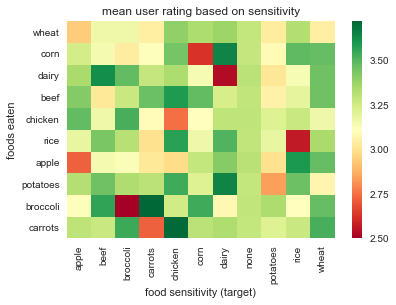

In [9]:
hm = plt.axes()
hm = sns.heatmap(by_targ,ax=hm, cmap='RdYlGn')   # red square == low average rating
hm.set_title('mean user rating based on sensitivity')
hm.set_xlabel('food sensitivity (target)')
hm.set_ylabel('foods eaten')

From the heat map we can clearly see that if a user has a sensitivity towards a specific food, they will, on average, rate the food lower. We can also see that if a user does not have a sensitivity, on average they will rate all foods the same.

I will create a table of user's rating difference from the mean. That way users rating variance will stand out in the dataset. Then if the variance is 

$\Delta$ rating = user_rating - mean_none_rating

I can add a multiplier to the negative $\Delta$ ratings to emphasize them.

In [10]:
mean_none = by_targ['none'].mean()    # take the mean none rating for all foods
def rating_diff(x,mean_none,emph):
    '''
    Function to take the difference of the mean user rating for each food sensitivity target and the mean none target
    if the difference is negative it will multiply it by a factor (c)
    '''
    delta = x-mean_none
    c = emph    # "emphasis factor"
    
    if delta < 0:
        delta = delta*c
    return delta


Now I can take the user ratings and apply the rating diff function

In [11]:
emph = 10    # negative emph factor
user_diffs = user_data.drop('target',axis=1).applymap(lambda x: rating_diff(x,mean_none,emph))

In [12]:
user_diffs['target'] = user_data['target']
user_diffs.head()


,wheat,corn,dairy,beef,chicken,rice,apple,potatoes,broccoli,carrots,target
user_id,,,,,,,,,,,
0,1.708611,0.708611,0.708611,0.708611,-12.913889,0.708611,-12.913889,0.708611,0.708611,1.708611,none
1,0.708611,0.708611,-12.913889,1.708611,0.708611,-2.913889,0.708611,1.708611,0.708611,-12.913889,none
2,1.708611,0.708611,-2.913889,1.708611,0.708611,0.708611,0.708611,0.708611,0.708611,-2.913889,none
3,-22.913889,0.708611,0.708611,-2.913889,0.708611,0.708611,-2.913889,0.708611,0.708611,-2.913889,none
4,0.708611,1.708611,-22.913889,0.708611,-12.913889,0.708611,0.708611,0.708611,0.708611,-12.913889,none


*user_diffs* is now a dataframe with the user rating difference from the mean rating for people without sensitivities. The negative ratings are emphasized by a factor of 10. 

Now we will see if a model can pick out the sensitivity

In [13]:
from sklearn.model_selection import train_test_split 

In [14]:
X = user_diffs.drop('target',axis=1)   # selecting all the food ratings
y = user_diffs['target']            #  setting the target as the output

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

In [16]:
from sklearn.svm import SVC

In [17]:
sensitivity_model = SVC()

In [18]:
sensitivity_model.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
predictions = sensitivity_model.predict(X_test)

In [20]:
from sklearn.metrics import classification_report,confusion_matrix

In [21]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      apple       0.00      0.00      0.00        27
       beef       0.00      0.00      0.00        27
   broccoli       0.00      0.00      0.00        22
    carrots       0.00      0.00      0.00        17
    chicken       0.00      0.00      0.00        25
       corn       0.00      0.00      0.00        28
      dairy       0.00      0.00      0.00        27
       none       0.95      1.00      0.97      4752
   potatoes       0.00      0.00      0.00        28
       rice       0.00      0.00      0.00        22
      wheat       0.00      0.00      0.00        25

avg / total       0.90      0.95      0.93      5000



C:\Users\hasem\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


So basically the model predicted that every user had a 'none' sensitivity. Since only %5 of the population had a sensitivity the model was right 95% of the time!! hmmmm... maybe we can change the emphasis factor

In [22]:
emph = 100    # negative emph factor
user_diffs = user_data.drop('target',axis=1).applymap(lambda x: rating_diff(x,mean_none,emph))
user_diffs['target'] = user_data['target']
user_diffs.head()

,wheat,corn,dairy,beef,chicken,rice,apple,potatoes,broccoli,carrots,target
user_id,,,,,,,,,,,
0,1.708611,0.708611,0.708611,0.708611,-129.138892,0.708611,-129.138892,0.708611,0.708611,1.708611,none
1,0.708611,0.708611,-129.138892,1.708611,0.708611,-29.138892,0.708611,1.708611,0.708611,-129.138892,none
2,1.708611,0.708611,-29.138892,1.708611,0.708611,0.708611,0.708611,0.708611,0.708611,-29.138892,none
3,-229.138892,0.708611,0.708611,-29.138892,0.708611,0.708611,-29.138892,0.708611,0.708611,-29.138892,none
4,0.708611,1.708611,-229.138892,0.708611,-129.138892,0.708611,0.708611,0.708611,0.708611,-129.138892,none


In [23]:
X = user_diffs.drop('target',axis=1)   # selecting all the food ratings
y = user_diffs['target']            #  setting the target as the output
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)
sensitivity_model = SVC()
sensitivity_model.fit(X_train,y_train)
predictions = sensitivity_model.predict(X_test)

In [24]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      apple       0.00      0.00      0.00        27
       beef       0.00      0.00      0.00        27
   broccoli       0.00      0.00      0.00        22
    carrots       0.00      0.00      0.00        17
    chicken       0.00      0.00      0.00        25
       corn       0.00      0.00      0.00        28
      dairy       0.00      0.00      0.00        27
       none       0.95      1.00      0.97      4752
   potatoes       0.00      0.00      0.00        28
       rice       0.00      0.00      0.00        22
      wheat       0.00      0.00      0.00        25

avg / total       0.90      0.95      0.93      5000



C:\Users\hasem\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Same exact result.  Maybe we should filter out all non-negative ratings and just work to see if we can identify the target based on those.  Maybe there is too much "noise" in the none target data. Maybe we can quantify the noise.

In [25]:
diff_vars = user_diffs.groupby('target').var()
by_var = diff_vars.transpose()

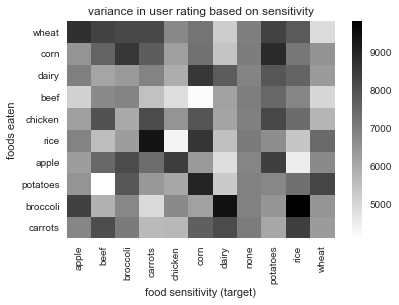

In [26]:
hv = plt.axes()
hv = sns.heatmap(by_var,ax=hv, cmap='binary')   # darker == higher variance
hv.set_title('variance in user rating based on sensitivity')
hv.set_xlabel('food sensitivity (target)')
hv.set_ylabel('foods eaten')

This doesnt give me anymore insight...

Now we will filter out positive differences and only look at data where the rating was bad. But first lets turn the emphasis factor back down to 1.

In [27]:
emph = 1    # negative emph factor
user_diffs = user_data.drop('target',axis=1).applymap(lambda x: rating_diff(x,mean_none,emph))
user_diffs['target'] = user_data['target']
user_diffs.head()

,wheat,corn,dairy,beef,chicken,rice,apple,potatoes,broccoli,carrots,target
user_id,,,,,,,,,,,
0,1.708611,0.708611,0.708611,0.708611,-1.291389,0.708611,-1.291389,0.708611,0.708611,1.708611,none
1,0.708611,0.708611,-1.291389,1.708611,0.708611,-0.291389,0.708611,1.708611,0.708611,-1.291389,none
2,1.708611,0.708611,-0.291389,1.708611,0.708611,0.708611,0.708611,0.708611,0.708611,-0.291389,none
3,-2.291389,0.708611,0.708611,-0.291389,0.708611,0.708611,-0.291389,0.708611,0.708611,-0.291389,none
4,0.708611,1.708611,-2.291389,0.708611,-1.291389,0.708611,0.708611,0.708611,0.708611,-1.291389,none


In [28]:
bad_ratings = user_diffs[user_diffs  < 0]        # this turns all positive values to NaN
bad_ratings.fillna(0, inplace = True)                           # turns NaN's to 0 

In [29]:
bad_ratings.head()

,wheat,corn,dairy,beef,chicken,rice,apple,potatoes,broccoli,carrots,target
user_id,,,,,,,,,,,
0,0.000000,0.0,0.000000,0.000000,-1.291389,0.000000,-1.291389,0.0,0.0,0.000000,none
1,0.000000,0.0,-1.291389,0.000000,0.000000,-0.291389,0.000000,0.0,0.0,-1.291389,none
2,0.000000,0.0,-0.291389,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.291389,none
3,-2.291389,0.0,0.000000,-0.291389,0.000000,0.000000,-0.291389,0.0,0.0,-0.291389,none
4,0.000000,0.0,-2.291389,0.000000,-1.291389,0.000000,0.000000,0.0,0.0,-1.291389,none


In [30]:
X = bad_ratings.drop('target',axis=1)   # selecting all the food ratings
y = bad_ratings['target']            #  setting the target as the output
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)
sensitivity_model = SVC(kernel='rbf')
sensitivity_model.fit(X_train,y_train)
predictions = sensitivity_model.predict(X_test)

In [31]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

      apple       0.00      0.00      0.00        27
       beef       0.00      0.00      0.00        27
   broccoli       0.00      0.00      0.00        22
    carrots       0.00      0.00      0.00        17
    chicken       0.00      0.00      0.00        25
       corn       0.00      0.00      0.00        28
      dairy       0.00      0.00      0.00        27
       none       0.95      1.00      0.97      4752
   potatoes       0.00      0.00      0.00        28
       rice       0.00      0.00      0.00        22
      wheat       0.00      0.00      0.00        25

avg / total       0.90      0.95      0.93      5000



C:\Users\hasem\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


It still predicts all users have no sensitivity. However, clearly on average a user with a specific sensitivity rate that food lower.   WTF

I think what I am experiencing is, that there isn't enough of a grouping of similar ratings for any one target. Therefore the 'none' class centroid dominates all.

Maybe I can first try and identify wheather a food senstivity even exists at all. Get that prediction as accurate as possible, then try and identify specific foods just from the users who have been predicted to have a sensitivity. That would mostly eliminate the 'nones' from the data (hopefully).

## Just identifying if a senstivity exists
I will add a bianary variable, 0 for 'none' and 1 for anything else

In [32]:
user_data['sensitivity'] = np.where(user_data['target'] != 'none', 1, 0)
user_data.head(10)

,wheat,corn,dairy,beef,chicken,rice,apple,potatoes,broccoli,carrots,target,sensitivity
user_id,,,,,,,,,,,,
0,5.0,4.0,4.0,4.0,2.0,4.0,2.0,4.0,4.0,5.0,none,0
1,4.0,4.0,2.0,5.0,4.0,3.0,4.0,5.0,4.0,2.0,none,0
2,5.0,4.0,3.0,5.0,4.0,4.0,4.0,4.0,4.0,3.0,none,0
3,1.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,3.0,none,0
4,4.0,5.0,1.0,4.0,2.0,4.0,4.0,4.0,4.0,2.0,none,0
5,3.0,3.0,5.0,5.0,4.0,5.0,4.0,1.0,1.0,4.0,none,0
6,4.0,1.0,4.0,4.0,5.0,1.0,1.0,3.0,3.0,2.0,none,0
7,5.0,1.0,1.0,4.0,4.0,5.0,1.0,2.0,4.0,4.0,none,0
8,5.0,4.0,1.0,5.0,1.0,5.0,3.0,2.0,1.0,4.0,wheat,1


## Im going to try a support vector machine first

In [33]:
X = user_data.drop(['target','sensitivity'],axis=1)   # selecting all the food ratings
y = user_data['sensitivity']            #  setting the target as the output
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)
sensitivity_model = SVC()
sensitivity_model.fit(X_train,y_train)
predictions = sensitivity_model.predict(X_test)

In [34]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97      4752
          1       0.00      0.00      0.00       248

avg / total       0.90      0.95      0.93      5000



C:\Users\hasem\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


this is stupid

maybe PCA will reveal something for me

In [35]:
from sklearn.decomposition import PCA

In [36]:
pca=PCA(n_components=3)

In [37]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [41]:
x_pca = pca.transform(X)
x_pca.shape

(10000, 3)

In [42]:
from mpl_toolkits.mplot3d import Axes3D

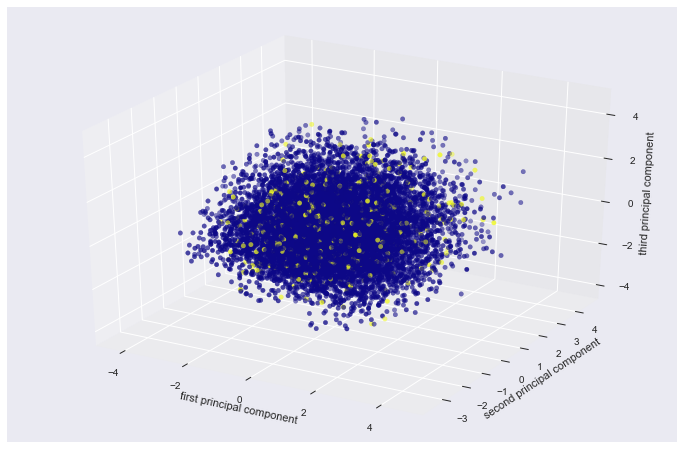

In [74]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(x_pca[:,0],x_pca[:,1],x_pca[:,2],c = user_data['sensitivity'],cmap='plasma')
ax.set_xlabel('first principal component')
ax.set_ylabel('second principal component')
ax.set_zlabel('third principal component')

yeah, thats a shit storm cloud

In [50]:
pca2 = PCA(n_components=2)

In [51]:
pca2.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [52]:
x_pca2 = pca2.transform(X)
x_pca2.shape

(10000, 2)

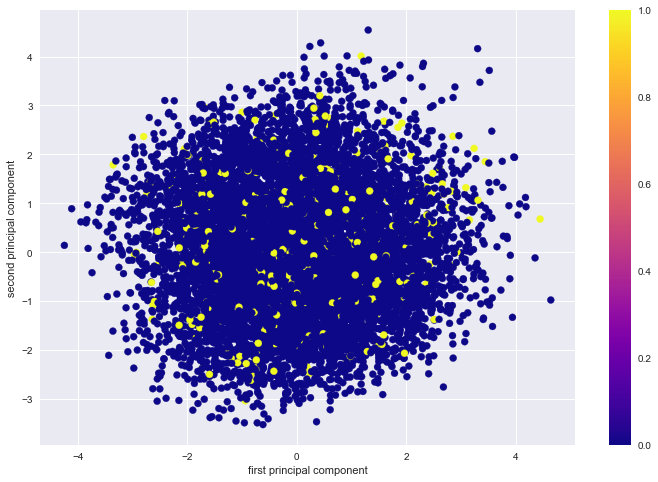

In [72]:
plt.figure(figsize=(12,8))
plt.scatter(x= x_pca2[:,0], y = x_pca2[:,1], c = user_data['sensitivity'], cmap = 'plasma')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.colorbar()

It doesnt look like PCA is the answer.    I am going to back up a minute.

I can see a difference in the average user rating of a food if they have a sensitivity to it, just by taking the mean raiting based on user sensitivity.

Maybe I can use a K nearest neighbor model that has the groups centroids at the mean rating based on sensitivity.  If the users rating for a food is close to that mean then put it into that class.  